#Imports & basic config

In [1]:
!pip install -q "transformers>=4.48.0" peft kagglehub fire

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 3.6 MB/s eta 0:00:00


In [2]:
import transformers
print(transformers.__version__)


4.57.2


In [3]:

!pip install -q "transformers>=4.48.0" peft kagglehub fire sentence-transformers

In [4]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME = 'UW_Courses/eep596 dl/final_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/UW_Courses/eep596 dl/final_project


In [5]:

# ==========================================
# 1. Install Dependencies
# ==========================================

import transformers
print(f"Transformers version: {transformers.__version__}")

import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from collections import Counter
from typing import List, Any
import kagglehub

# Import necessary models and tools
from transformers import BertTokenizer, BertModel
# [NEW] Import CLIP models for PubMedCLIP
from transformers import CLIPVisionModel, CLIPImageProcessor

# Modern amp imports
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.utils.data import Dataset, DataLoader
# [CRITICAL] Import checkpoint function explicitly
from torch.utils.checkpoint import checkpoint
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, util



Transformers version: 4.57.2


In [6]:

# ==========================================
# 2. Configuration and Setup
# ==========================================
class Config:
    seed = 42
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training parameters
    # ViT usually takes more VRAM than ResNet, so we might need to adjust batch size
    batch_size = 32
    num_epochs = 100
    learning_rate = 5e-5
    weight_decay = 1e-4
    max_len = 128
    patience = 10

    # Data path
    data_dir = Path("./vqa_data_medical")

    # Checkpoint path (Saving to a new directory to avoid overwriting ResNet baseline)
    checkpoint_dir = Path("PubMedCLIP_BERT")
    checkpoint_path = checkpoint_dir / "best_model.pth"

    # [NEW] PubMedCLIP Model ID
    # Using a reliable HuggingFace port of PubMedCLIP
    pubmed_clip_id = "flaviagiammarino/pubmed-clip-vit-base-patch32"

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(Config.seed)
print(f"Device: {Config.device}")

# Ensure checkpoint directory exists
Config.checkpoint_dir.mkdir(parents=True, exist_ok=True)


Device: cuda


#VQADataset + training wrapper dataset

In [7]:

# ==========================================
# 3. Data Download and Preprocessing
# ==========================================
def prepare_data():
    # 1. Download
    print("Downloading dataset...")
    kaggle_root = Path(kagglehub.dataset_download("mitanshuchakrawarty/medical-visual-question-answering"))

    # Find CSV/JSON files
    candidates = list(kaggle_root.rglob("*.csv")) + list(kaggle_root.rglob("*.json"))
    if not candidates:
        raise FileNotFoundError("No csv/json found.")
    data_path = candidates[0]

    # Read and unify columns
    if data_path.suffix == ".json":
        df = pd.read_json(data_path)
    else:
        df = pd.read_csv(data_path)

    # Simple column mapping
    df = df.rename(columns={"image_name": "image_id", "question": "question", "answer": "answer"})
    df["image_id"] = df["image_id"].astype(str).apply(lambda x: Path(str(x)).stem)

    # Split
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=Config.seed)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=Config.seed)

    # Prepare image path Map
    image_map = {}
    for ext in ["png", "jpg", "jpeg"]:
        for p in kaggle_root.rglob(f"*.{ext}"):
            image_map[p.stem] = p

    return train_df, val_df, test_df, image_map

train_df, val_df, test_df, image_map = prepare_data()
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Build Label Vocabulary
def build_vocab(df_list):
    all_answers = []
    for df in df_list:
        all_answers.extend(df["answer"].astype(str).tolist())

    counter = Counter(all_answers)
    vocab = sorted(counter.keys())

    answer2idx = {ans: i for i, ans in enumerate(vocab)}
    idx2answer = {i: ans for i, ans in enumerate(vocab)}
    return answer2idx, idx2answer

answer2idx, idx2answer = build_vocab([train_df, val_df, test_df])
NUM_ANSWERS = len(answer2idx)
print(f"Total Labels: {NUM_ANSWERS}")

Using Colab cache for faster access to the 'medical-visual-question-answering' dataset.
Train: 1798, Val: 225, Test: 225
Total Labels: 557


#Preparing Dataset

In [8]:

# ==========================================
# 4. Dataset Definition (Updated for CLIPProcessor)
# ==========================================
class MedicalVQADataset(Dataset):
    def __init__(self, df, image_map, answer2idx, image_processor, tokenizer, max_len=128):
        self.df = df
        self.image_map = image_map
        self.answer2idx = answer2idx
        self.image_processor = image_processor # [NEW] Use CLIPImageProcessor
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row["image_id"]
        question = str(row["question"])
        answer = str(row["answer"])

        # 1. Process Image
        img_path = self.image_map.get(img_id)
        if img_path is None:
            image = Image.new('RGB', (224, 224))
        else:
            image = Image.open(img_path).convert("RGB")

        # [NEW] Use CLIP processor instead of manual transforms
        # This handles resizing and normalization specific to PubMedCLIP
        img_inputs = self.image_processor(images=image, return_tensors="pt")
        # squeeze to remove batch dim: [1, 3, 224, 224] -> [3, 224, 224]
        pixel_values = img_inputs['pixel_values'].squeeze(0)

        # 2. Process Text (using BertTokenizer)
        encoding = self.tokenizer(
            question,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_len
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        # 3. Process Label
        label = self.answer2idx.get(answer, 0)

        return pixel_values, input_ids, attention_mask, torch.tensor(label, dtype=torch.long)

# [NEW] Initialize Processors
# PubMedCLIP image processor
image_processor = CLIPImageProcessor.from_pretrained(Config.pubmed_clip_id)
# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# DataLoaders
train_ds = MedicalVQADataset(train_df, image_map, answer2idx, image_processor, tokenizer, Config.max_len)
val_ds = MedicalVQADataset(val_df, image_map, answer2idx, image_processor, tokenizer, Config.max_len)
test_ds = MedicalVQADataset(test_df, image_map, answer2idx, image_processor, tokenizer, Config.max_len)

train_loader = DataLoader(train_ds, batch_size=Config.batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=Config.batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=Config.batch_size, shuffle=False, num_workers=2, pin_memory=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
len(test_ds)

225

#Model Training

In [9]:

# ==========================================
# 5. PubMedCLIP + BERT Model Architecture
# ==========================================
class PubMedCLIP_BERT_Model(nn.Module):
    def __init__(self, num_answers):
        super().__init__()
        # 1. Visual Encoder: PubMedCLIP (ViT-Base)
        # Replacing ResNet50 with PubMedCLIP Vision Model
        print(f"Loading Visual Encoder: {Config.pubmed_clip_id} ...")
        self.vision_encoder = CLIPVisionModel.from_pretrained(Config.pubmed_clip_id)

        # 2. Text Encoder: BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # 3. Fusion & Classifier
        # ResNet50 output was 2048. CLIP ViT-Base output is 768.
        # BERT output is 768.
        # Combined dim = 768 + 768 = 1536
        self.fc1 = nn.Linear(768 + 768, 1024)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_answers)

    def forward(self, pixel_values, input_ids, attention_mask):
        # [Visual Path]
        # We can use checkpointing here if needed, but ViT is often memory hungry
        if self.training:
             vision_output = checkpoint(
                lambda p: self.vision_encoder(pixel_values=p),
                pixel_values,
                use_reentrant=False
            )
        else:
            vision_output = self.vision_encoder(pixel_values=pixel_values)

        # Extract [CLS] token equivalent from CLIP (pooler_output)
        # pooler_output shape: [Batch, 768]
        img_feat = vision_output.pooler_output

        # [Text Path]
        if self.training:
            bert_output = checkpoint(
                lambda i, m: self.bert(input_ids=i, attention_mask=m),
                input_ids,
                attention_mask,
                use_reentrant=False
            )
        else:
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        txt_feat = bert_output.last_hidden_state[:, 0, :] # [Batch, 768]

        # [Fusion]
        combined = torch.cat((img_feat, txt_feat), dim=1) # [Batch, 1536]

        x = self.fc1(combined)
        x = torch.relu(x)
        x = self.dropout(x)
        logits = self.fc2(x)

        return logits

model = PubMedCLIP_BERT_Model(NUM_ANSWERS).to(Config.device)

Loading Visual Encoder: flaviagiammarino/pubmed-clip-vit-base-patch32 ...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:

# ==========================================
# 6. Training Setup
# ==========================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.num_epochs)
scaler = torch.amp.GradScaler("cuda")

def train_one_epoch(epoch_idx):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch_idx+1}/{Config.num_epochs} [Train]")
    for imgs, ids, mask, labels in pbar:
        imgs, ids, mask, labels = imgs.to(Config.device), ids.to(Config.device), mask.to(Config.device), labels.to(Config.device)

        optimizer.zero_grad()

        with autocast("cuda"):
            outputs = model(imgs, ids, mask)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': loss.item(), 'acc': correct/total})

    return running_loss / len(train_loader), correct / total

def validate(loader, desc="Val"):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc=desc)
        for imgs, ids, mask, labels in pbar:
            imgs, ids, mask, labels = imgs.to(Config.device), ids.to(Config.device), mask.to(Config.device), labels.to(Config.device)

            with autocast("cuda"):
                outputs = model(imgs, ids, mask)
                loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total

In [ ]:

# ==========================================
# 7. Resume Logic
# ==========================================
start_epoch = 0
best_val_acc = 0.0
early_stopping_counter = 0
history = []

resume_path = Config.checkpoint_dir / "latest_checkpoint.pth"
best_model_path = Config.checkpoint_dir / "best_model.pth"

if resume_path.exists():
    print(f"🔄 Found checkpoint at {resume_path}. Resuming training...")
    ckpt = torch.load(resume_path, map_location=Config.device)

    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    if 'scaler_state_dict' in ckpt:
        scaler.load_state_dict(ckpt['scaler_state_dict'])

    start_epoch = ckpt['epoch'] + 1
    best_val_acc = ckpt['best_val_acc']
    history = ckpt.get('history', [])
    early_stopping_counter = ckpt.get('early_stopping_counter', 0)

    print(f"   >>> Resuming from Epoch {start_epoch+1}")
    print(f"   >>> Best Val Acc so far: {best_val_acc:.4f}")
else:
    print("🚀 No checkpoint found. Starting training from scratch.")

# ==========================================
# 8. Main Training Loop
# ==========================================
print(f"Checkpoints will be saved to: {Config.checkpoint_dir}")

for epoch in range(start_epoch, Config.num_epochs):
    train_loss, train_acc = train_one_epoch(epoch)
    val_loss, val_acc = validate(val_loader)
    scheduler.step()

    print(f"Epoch {epoch+1}/{Config.num_epochs}: Train Loss={train_loss:.4f} Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Acc={val_acc:.4f}")

    history.append({
        "epoch": epoch+1,
        "train_loss": train_loss, "train_acc": train_acc,
        "val_loss": val_loss, "val_acc": val_acc
    })

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        early_stopping_counter = 0
        current_state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'scaler_state_dict': scaler.state_dict(),
            'best_val_acc': best_val_acc,
            'history': history,
            'early_stopping_counter': early_stopping_counter
        }
        torch.save(current_state, best_model_path)
        print(f">>> 🌟 New Best Model saved to {best_model_path}!")
    else:
        early_stopping_counter += 1
        print(f"   >>> No improvement. Counter: {early_stopping_counter}/{Config.patience}")

    latest_state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'best_val_acc': best_val_acc,
        'history': history,
        'early_stopping_counter': early_stopping_counter
    }
    torch.save(latest_state, resume_path)

    if early_stopping_counter >= Config.patience:
        print(f"🛑 Early stopping triggered after {Config.patience} epochs.")
        break

print("Training Complete!")

🔄 Found checkpoint at PubMedCLIP_BERT/latest_checkpoint.pth. Resuming training...
   >>> Resuming from Epoch 2
   >>> Best Val Acc so far: 0.1867
Checkpoints will be saved to: PubMedCLIP_BERT


Val: 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]


Epoch 2/100: Train Loss=3.4592 Acc=0.2347 | Val Loss=4.2371 Acc=0.2489
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


Epoch 3/100: Train Loss=3.5419 Acc=0.2892 | Val Loss=4.2347 Acc=0.2756
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


Epoch 4/100: Train Loss=3.3504 Acc=0.3515 | Val Loss=4.2772 Acc=0.2400
   >>> No improvement. Counter: 1/10


Val: 100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


Epoch 5/100: Train Loss=3.1936 Acc=0.3960 | Val Loss=4.2312 Acc=0.2978
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Epoch 6/100: Train Loss=3.0111 Acc=0.4372 | Val Loss=4.2655 Acc=0.3156
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:03<00:00,  2.12it/s]


Epoch 7/100: Train Loss=2.8698 Acc=0.4689 | Val Loss=4.3754 Acc=0.2800
   >>> No improvement. Counter: 1/10


Val: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 8/100: Train Loss=2.7202 Acc=0.4989 | Val Loss=4.3119 Acc=0.3111
   >>> No improvement. Counter: 2/10


Val: 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


Epoch 9/100: Train Loss=2.5618 Acc=0.5195 | Val Loss=4.3673 Acc=0.3067
   >>> No improvement. Counter: 3/10


Val: 100%|██████████| 8/8 [00:03<00:00,  2.08it/s]


Epoch 10/100: Train Loss=2.4245 Acc=0.5478 | Val Loss=4.3517 Acc=0.3244
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 11/100: Train Loss=2.2819 Acc=0.5501 | Val Loss=4.3378 Acc=0.3378
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Epoch 12/100: Train Loss=2.1368 Acc=0.5779 | Val Loss=4.4262 Acc=0.3111
   >>> No improvement. Counter: 1/10


Val: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 13/100: Train Loss=1.9782 Acc=0.5845 | Val Loss=4.4232 Acc=0.3022
   >>> No improvement. Counter: 2/10


Val: 100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Epoch 14/100: Train Loss=1.8153 Acc=0.6268 | Val Loss=4.3441 Acc=0.3378
   >>> No improvement. Counter: 3/10


Val: 100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


Epoch 15/100: Train Loss=1.6956 Acc=0.6485 | Val Loss=4.3683 Acc=0.3244
   >>> No improvement. Counter: 4/10


Val: 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Epoch 16/100: Train Loss=1.5426 Acc=0.6785 | Val Loss=4.2539 Acc=0.3511
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:03<00:00,  2.26it/s]


Epoch 17/100: Train Loss=1.3506 Acc=0.7253 | Val Loss=4.2385 Acc=0.3600
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:05<00:00,  1.58it/s]


Epoch 18/100: Train Loss=1.1828 Acc=0.7747 | Val Loss=4.3111 Acc=0.3467
   >>> No improvement. Counter: 1/10


Val: 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


Epoch 19/100: Train Loss=0.9851 Acc=0.8037 | Val Loss=4.1877 Acc=0.3822
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:03<00:00,  2.40it/s]


Epoch 20/100: Train Loss=0.8233 Acc=0.8493 | Val Loss=4.1281 Acc=0.3956
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]


Epoch 21/100: Train Loss=0.6945 Acc=0.8754 | Val Loss=4.2014 Acc=0.4400
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Epoch 22/100: Train Loss=0.5608 Acc=0.9116 | Val Loss=4.0093 Acc=0.4356
   >>> No improvement. Counter: 1/10


Val: 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]


Epoch 23/100: Train Loss=0.4685 Acc=0.9383 | Val Loss=3.9794 Acc=0.4533
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


Epoch 24/100: Train Loss=0.3829 Acc=0.9477 | Val Loss=3.9640 Acc=0.4578
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Epoch 25/100: Train Loss=0.3065 Acc=0.9689 | Val Loss=3.8999 Acc=0.4400
   >>> No improvement. Counter: 1/10


Val: 100%|██████████| 8/8 [00:04<00:00,  1.92it/s]


Epoch 26/100: Train Loss=0.2625 Acc=0.9700 | Val Loss=3.8768 Acc=0.4889
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


Epoch 27/100: Train Loss=0.2586 Acc=0.9672 | Val Loss=3.8434 Acc=0.4711
   >>> No improvement. Counter: 1/10


Val: 100%|██████████| 8/8 [00:03<00:00,  2.23it/s]


Epoch 28/100: Train Loss=0.2196 Acc=0.9744 | Val Loss=3.8963 Acc=0.4800
   >>> No improvement. Counter: 2/10


Val: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 29/100: Train Loss=0.1873 Acc=0.9811 | Val Loss=3.8757 Acc=0.4844
   >>> No improvement. Counter: 3/10


Val: 100%|██████████| 8/8 [00:03<00:00,  2.42it/s]


Epoch 30/100: Train Loss=0.1374 Acc=0.9894 | Val Loss=3.9176 Acc=0.4800
   >>> No improvement. Counter: 4/10


Val: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Epoch 31/100: Train Loss=0.1197 Acc=0.9917 | Val Loss=3.8481 Acc=0.5111
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


Epoch 32/100: Train Loss=0.1044 Acc=0.9900 | Val Loss=3.9461 Acc=0.5156
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:05<00:00,  1.56it/s]


Epoch 33/100: Train Loss=0.0896 Acc=0.9983 | Val Loss=3.9384 Acc=0.5111
   >>> No improvement. Counter: 1/10


Val: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Epoch 34/100: Train Loss=0.0880 Acc=0.9928 | Val Loss=3.9403 Acc=0.5067
   >>> No improvement. Counter: 2/10


Val: 100%|██████████| 8/8 [00:03<00:00,  2.50it/s]


Epoch 35/100: Train Loss=0.0738 Acc=0.9950 | Val Loss=3.9307 Acc=0.5067
   >>> No improvement. Counter: 3/10


Val: 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]


Epoch 36/100: Train Loss=0.0689 Acc=0.9961 | Val Loss=3.9738 Acc=0.5067
   >>> No improvement. Counter: 4/10


Val: 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


Epoch 37/100: Train Loss=0.0629 Acc=0.9978 | Val Loss=4.0104 Acc=0.5200
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:03<00:00,  2.17it/s]


Epoch 38/100: Train Loss=0.0594 Acc=0.9978 | Val Loss=4.0322 Acc=0.5156
   >>> No improvement. Counter: 1/10


Val: 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


Epoch 39/100: Train Loss=0.0506 Acc=0.9978 | Val Loss=4.0670 Acc=0.5111
   >>> No improvement. Counter: 2/10


Val: 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]


Epoch 40/100: Train Loss=0.0516 Acc=0.9983 | Val Loss=4.0332 Acc=0.5111
   >>> No improvement. Counter: 3/10


Val: 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


Epoch 41/100: Train Loss=0.0456 Acc=0.9978 | Val Loss=4.0674 Acc=0.5200
   >>> No improvement. Counter: 4/10


Val: 100%|██████████| 8/8 [00:03<00:00,  2.56it/s]


Epoch 42/100: Train Loss=0.0402 Acc=0.9994 | Val Loss=4.0977 Acc=0.5111
   >>> No improvement. Counter: 5/10


Val: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Epoch 43/100: Train Loss=0.0353 Acc=0.9994 | Val Loss=4.0967 Acc=0.5200
   >>> No improvement. Counter: 6/10


Val: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


Epoch 44/100: Train Loss=0.0354 Acc=1.0000 | Val Loss=4.1450 Acc=0.5289
>>> 🌟 New Best Model saved to PubMedCLIP_BERT/best_model.pth!


Val: 100%|██████████| 8/8 [00:04<00:00,  1.87it/s]


Epoch 45/100: Train Loss=0.0334 Acc=1.0000 | Val Loss=4.1045 Acc=0.5200
   >>> No improvement. Counter: 1/10


Val: 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


Epoch 46/100: Train Loss=0.0340 Acc=0.9994 | Val Loss=4.1385 Acc=0.5156
   >>> No improvement. Counter: 2/10


Val: 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]


Epoch 47/100: Train Loss=0.0324 Acc=0.9994 | Val Loss=4.1545 Acc=0.5156
   >>> No improvement. Counter: 3/10


Val: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 48/100: Train Loss=0.0285 Acc=0.9989 | Val Loss=4.1335 Acc=0.5022
   >>> No improvement. Counter: 4/10


Val: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch 49/100: Train Loss=0.0285 Acc=0.9994 | Val Loss=4.1489 Acc=0.5156
   >>> No improvement. Counter: 5/10


Val: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 50/100: Train Loss=0.0295 Acc=1.0000 | Val Loss=4.1580 Acc=0.5111
   >>> No improvement. Counter: 6/10


Val: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Epoch 51/100: Train Loss=0.0260 Acc=0.9994 | Val Loss=4.2022 Acc=0.5200
   >>> No improvement. Counter: 7/10


Val: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Epoch 52/100: Train Loss=0.0267 Acc=0.9989 | Val Loss=4.1681 Acc=0.5022
   >>> No improvement. Counter: 8/10


Val: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 53/100: Train Loss=0.0224 Acc=1.0000 | Val Loss=4.1938 Acc=0.5067
   >>> No improvement. Counter: 9/10


Val: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 54/100: Train Loss=0.0215 Acc=1.0000 | Val Loss=4.1937 Acc=0.5067
   >>> No improvement. Counter: 10/10
🛑 Early stopping triggered after 10 epochs.
Training Complete!


#Evaluation

In [11]:

# ==========================================
# 9. Final Evaluation
# ==========================================
print("\nRunning Final Evaluation...")
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
best_model_path = Config.checkpoint_dir / "best_model.pth"
if best_model_path.exists():
    print(f"Loading best model from {best_model_path}...")
    best_ckpt = torch.load(best_model_path, map_location=Config.device)
    if 'model_state_dict' in best_ckpt:
        model.load_state_dict(best_ckpt['model_state_dict'])
    else:
        model.load_state_dict(best_ckpt)

model.eval()
predictions, ground_truths, similarities = [], [], []

with torch.no_grad():
    for imgs, ids, mask, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(Config.device)
        ids = ids.to(Config.device)
        mask = mask.to(Config.device)
        labels = labels.to(Config.device)

        with autocast("cuda"):
            outputs = model(imgs, ids, mask)

        _, preds = torch.max(outputs, 1)

        for p, g in zip(preds, labels):
            pred_text = idx2answer[p.item()]
            gt_text = idx2answer[g.item()]

            predictions.append(pred_text)
            ground_truths.append(gt_text)

            p_clean = pred_text.replace("_", " ").lower().strip()
            g_clean = gt_text.replace("_", " ").lower().strip()

            emb1 = sbert_model.encode(p_clean, convert_to_tensor=True)
            emb2 = sbert_model.encode(g_clean, convert_to_tensor=True)
            sim = util.cos_sim(emb1, emb2).item()
            similarities.append(sim)

df_results = pd.DataFrame({
    "gt_answer": ground_truths,
    "pred_answer": predictions,
    "is_correct": [1 if p.lower().strip() == g.lower().strip() else 0 for p, g in zip(predictions, ground_truths)],
    "similarity": similarities
})

final_acc = df_results["is_correct"].mean()
avg_sim = df_results["similarity"].mean()

print("="*30)
print(f"Final Test Accuracy: {final_acc:.4f}")
print(f"Final SBERT Similarity: {avg_sim:.4f}")
print("="*30)



Running Final Evaluation...
Loading best model from PubMedCLIP_BERT/best_model.pth...


Testing: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]

Final Test Accuracy: 0.6044
Final SBERT Similarity: 0.7078


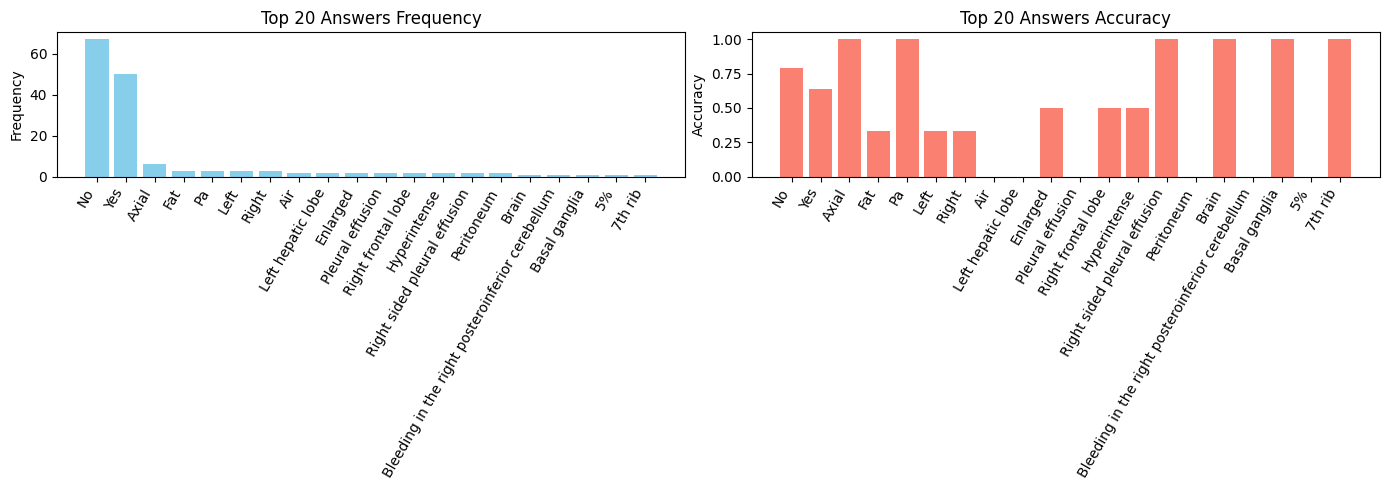

NameError: name 'history' is not defined

In [12]:

# ==========================================
# 10. Visualization
# ==========================================
# 10.1 Statistics
df_results['gt_answer'] = df_results['gt_answer'].apply(lambda x: x.lower().strip().capitalize())
stats = df_results.groupby("gt_answer")["is_correct"].agg(["count", "mean"]).rename(columns={"count": "freq", "mean": "acc"}).sort_values("freq", ascending=False)

TOP_N = 20
top_stats = stats.head(TOP_N)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.bar(range(len(top_stats)), top_stats["freq"], color='skyblue')
plt.xticks(range(len(top_stats)), top_stats.index, rotation=60, ha="right")
plt.ylabel("Frequency")
plt.title(f"Top {TOP_N} Answers Frequency")

plt.subplot(1, 2, 2)
plt.bar(range(len(top_stats)), top_stats["acc"], color='salmon')
plt.xticks(range(len(top_stats)), top_stats.index, rotation=60, ha="right")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.title(f"Top {TOP_N} Answers Accuracy")
plt.tight_layout()
plt.show()

# 10.2 Training History
if history:
    epochs = [x['epoch'] for x in history]
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_accs = [x['val_acc'] for x in history]

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train', marker='o')
    plt.plot(epochs, val_losses, label='Val', marker='o')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train', marker='o')
    plt.plot(epochs, val_accs, label='Val', marker='o')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()




Generating Qualitative Examples...


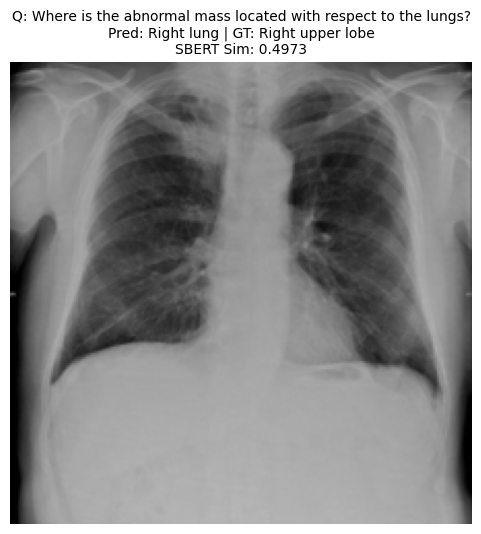

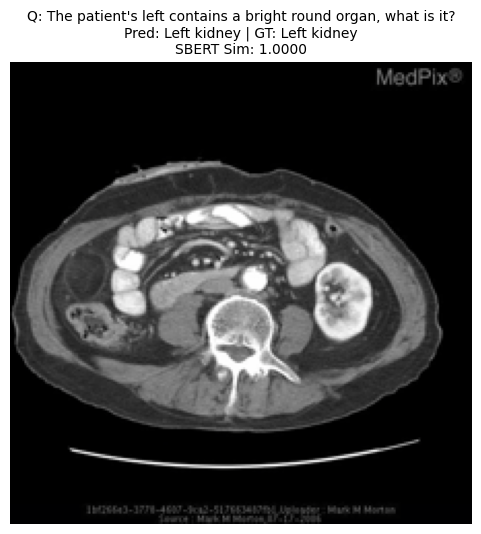

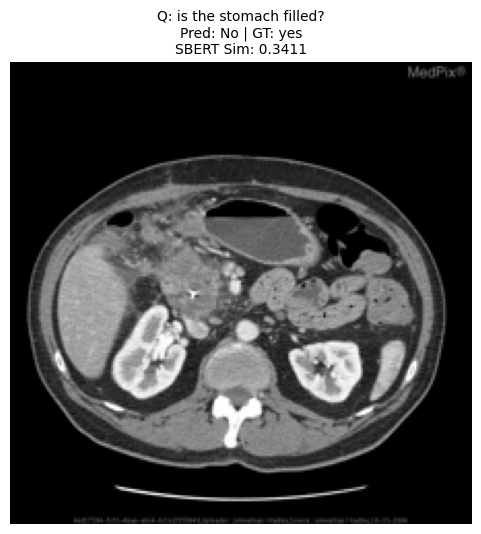

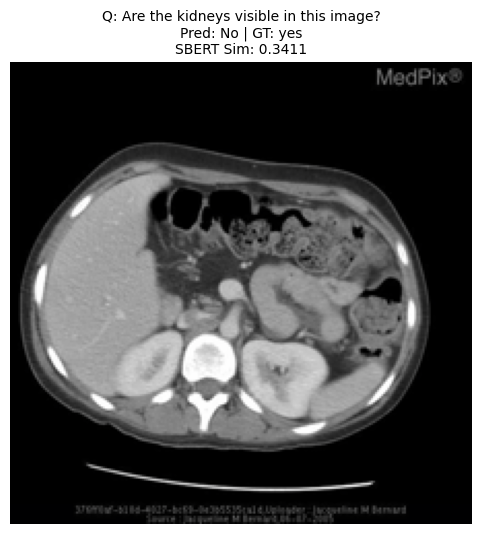

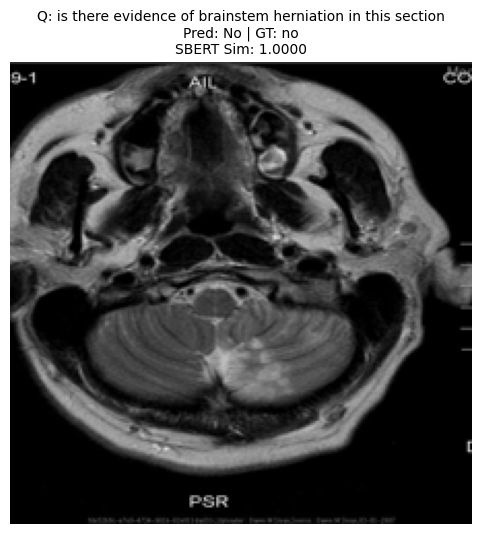

In [ ]:
# 10.3 Image Predictions
print("\nGenerating Qualitative Examples...")
def preprocess_answer(answer):
    return answer.replace('_', ' ')

count = 0
max_examples = 5

with torch.no_grad():
    for batch_idx, (imgs, ids, mask, labels) in enumerate(test_loader):
        imgs = imgs.to(Config.device)
        ids = ids.to(Config.device)
        mask = mask.to(Config.device)
        labels = labels.to(Config.device)

        with autocast("cuda"):
            outputs = model(imgs, ids, mask)

        _, preds = torch.max(outputs, 1)

        for i in range(imgs.size(0)):
            if count >= max_examples:
                break
            pred_idx = preds[i].item()
            label_idx = labels[i].item()
            predicted_answer = preprocess_answer(idx2answer[pred_idx])
            actual_answer = preprocess_answer(idx2answer[label_idx])

            global_idx = batch_idx * test_loader.batch_size + i
            if global_idx < len(test_ds):
                question = test_ds.df.iloc[global_idx]['question']
            else:
                question = "Unknown"

            emb1 = sbert_model.encode(predicted_answer, convert_to_tensor=True)
            emb2 = sbert_model.encode(actual_answer, convert_to_tensor=True)
            similarity = util.cos_sim(emb1, emb2).item()

            # Undo normalization for CLIP (approximate)
            # CLIP uses mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]
            img_tensor = imgs[i].cpu()
            mean = torch.tensor([0.4814, 0.4578, 0.4082]).view(3, 1, 1)
            std = torch.tensor([0.2686, 0.2613, 0.2757]).view(3, 1, 1)
            img_disp = img_tensor * std + mean
            img_disp = torch.clamp(img_disp, 0, 1)
            img_np = img_disp.permute(1, 2, 0).numpy()

            plt.figure(figsize=(6, 6))
            plt.imshow(img_np)
            plt.title(f"Q: {question}\nPred: {predicted_answer} | GT: {actual_answer}\nSBERT Sim: {similarity:.4f}", fontsize=10)
            plt.axis('off')
            plt.show()

            count += 1
        if count >= max_examples:
            break